In [166]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

tables = {
    "OE_Activity": "../data/database_backups_csv/OE/OE_Activity.csv",
    "OE_Locations": "../data/database_backups_csv/OE/OE_Locations.csv",
    "OE_Products": "../data/database_backups_csv/OE/OE_Products.csv",
}

column_names = {
    "OE_Activity": ["ActivityCode","UserID","WorkCode","AssignmentID","ProductID","Quantity","Timestamp","LocationID"],
    "OE_Locations": ["LocationID","Aisle","Bay","Level","Slot"],
    "OE_Products": ["ProductID","ProductCode","UnitOfMeasure","Weight","Cube","Length","Width","Height"],
}

dfs = {}
for name, fp in tables.items():
    dfs[name] = pd.read_csv(fp, header=None, names=column_names[name])

In [167]:
for t in ["OE_Activity", "OE_Locations", "OE_Products"]:
    print("=" * 80)
    print(f"Table: {t}")

    df = dfs[t]
    print(f"Dimensions: ({df.shape[0]} rows, {df.shape[1]} columns)\n")

    display(df.head(3))

    # Columns and data types + quick summary stats
    schema_df = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_missing": df.isna().sum(),
        "n_unique": df.nunique(dropna=True),
    })

    # Numeric summaries
    num_df = df.select_dtypes(include="number")
    schema_df["min"] = num_df.min()
    schema_df["max"] = num_df.max()
    schema_df["mean"] = num_df.mean()

    display(schema_df)
    print("\n")

Table: OE_Activity
Dimensions: (96132 rows, 8 columns)



,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID
0,PickPut,419,20,7954566,4289.0,1.0,2025-11-10 11:37:14.160,826367.0
1,AssignmentOpen,64,10,7954429,NaN,NaN,2025-11-10 11:38:34.043,NaN
2,PickPut,419,20,7954541,6592.0,1.0,2025-11-10 11:39:42.330,14524.0


,dtype,n_missing,n_unique,min,max,mean
ActivityCode,object,0,2,NaN,NaN,NaN
UserID,int64,0,40,64.0,504.0,4.050262e+02
WorkCode,int64,0,3,10.0,30.0,2.642034e+01
AssignmentID,int64,0,42241,7717782.0,8042473.0,7.924902e+06
ProductID,float64,894,7691,1.0,57791.0,2.477778e+04
Quantity,float64,894,144,1.0,1143.0,8.453474e+00
Timestamp,object,0,95804,NaN,NaN,NaN
LocationID,float64,894,7669,1.0,8104198.0,8.932247e+05




Table: OE_Locations
Dimensions: (33519 rows, 5 columns)



,LocationID,Aisle,Bay,Level,Slot
0,1,10,24.0,1.0,1.0
1,2,40,5.0,4.0,4.0
2,3,40,9.0,1.0,2.0


,dtype,n_missing,n_unique,min,max,mean
LocationID,int64,0,33519,1.0,8034868.0,795274.768400
Aisle,object,0,52,NaN,NaN,NaN
Bay,float64,1,86,1.0,99.0,23.107107
Level,float64,1,12,1.0,50.0,3.687153
Slot,float64,1,35,1.0,35.0,3.019243




Table: OE_Products
Dimensions: (57671 rows, 8 columns)



,ProductID,ProductCode,UnitOfMeasure,Weight,Cube,Length,Width,Height
0,1,07062B2324X,CA,35.0000,0.938,NaN,NaN,NaN
1,2,0204800418,BX,2.7338,0.263,NaN,NaN,NaN
2,3,07062B1322Q,EA,0.6500,0.027,NaN,NaN,NaN


,dtype,n_missing,n_unique,min,max,mean
ProductID,int64,0,57671,1.0,57671.000,28836.000000
ProductCode,object,0,41981,NaN,NaN,NaN
UnitOfMeasure,object,0,55,NaN,NaN,NaN
Weight,float64,0,5572,0.0,7584.000,4.834848
Cube,float64,0,4009,0.0,421.296,0.623222
Length,float64,57671,0,NaN,NaN,NaN
Width,float64,57671,0,NaN,NaN,NaN
Height,float64,57671,0,NaN,NaN,NaN


In [168]:
# Load and process distance matrix
path = "../data/distance_matrices/distance_matrix_OE.csv"
Distance = pd.read_csv(path, index_col=0)

for c in Distance.columns:
    Distance[c] = pd.to_numeric(Distance[c], errors="coerce")

display(Distance.head())

,08|03|||,08|05|||,08|07|||,08|09|||,10|04|||,10|06|||,10|08|||,10|10|||,10|12|||,10|14|||,...,|Start L3,|Start L4,|Start L5,|Start L6,|Start R2,|Start R3,|Start R4,|Start R5,|Start R6,|Start SB
08|03|||,0,414,389,364,304,287,271,255,240,223,...,1094,1068,897,953,1080,1045,1089,913,969,994
08|05|||,25,0,414,389,329,312,296,280,265,248,...,1119,1093,922,978,1104,1070,1113,938,994,1018
08|07|||,50,25,0,414,354,337,321,305,290,273,...,1144,1118,947,1003,1129,1095,1138,963,1019,1043
08|09|||,75,50,25,0,379,362,346,330,315,298,...,1169,1143,972,1028,1154,1119,1163,988,1044,1068
10|04|||,484,459,434,410,0,19,35,51,67,81,...,1120,1074,958,838,929,1133,1087,971,854,767


In [169]:
OE_Activity = dfs["OE_Activity"]

# OE_Locations's Bay, level, slot all to int
OE_Locations = dfs["OE_Locations"]# Convert Bay, Level, Slot to integers (nullable Int64)
OE_Locations["Bay"]   = pd.to_numeric(OE_Locations["Bay"], errors="coerce").astype("Int64")
OE_Locations["Level"] = pd.to_numeric(OE_Locations["Level"], errors="coerce").astype("Int64")
OE_Locations["Slot"]  = pd.to_numeric(OE_Locations["Slot"], errors="coerce").astype("Int64")

OE_Products = dfs["OE_Products"][["ProductID", "ProductCode", "UnitOfMeasure", "Weight", "Cube"]]

In [170]:
# Check percentage of unique AssignmentID
assignment_counts = OE_Activity["AssignmentID"].value_counts()
unique_assignment_pct = (assignment_counts == 1).mean() * 100
print(f"Percentage of unique AssignmentID: {unique_assignment_pct:.2f}%")

Percentage of unique AssignmentID: 70.83%


In [171]:
# Compute WorkCode proportions, 3 possible values: 10 20, 30
workcode_counts = OE_Activity["WorkCode"].value_counts(normalize=True) * 100
print("WorkCode Proportions (%):")
print(workcode_counts)

WorkCode Proportions (%):
WorkCode
30    70.427121
20    23.349145
10     6.223734
Name: proportion, dtype: float64


In [172]:
# Reshape Distance matrix to long format for easier merging
dist_long = (
    Distance.stack(dropna=False)
    .rename("distance")
    .reset_index()
    .rename(columns={"level_0": "FromLoc", "level_1": "ToLoc"}))

/var/folders/hs/r4ck14j54v17d80mrc1wt5kw0000gn/T/ipykernel_24552/3174672105.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  Distance.stack(dropna=False)


In [173]:
oe = OE_Activity.copy()

oe["Timestamp"] = pd.to_datetime(oe["Timestamp"], errors="coerce")
oe = oe.dropna(subset=["Timestamp"]).copy()
oe["Day"] = oe["Timestamp"].dt.date

oe = oe.sort_values(["UserID", "Day", "Timestamp"]).reset_index(drop=True)

oe["Prev_Timestamp"] = oe.groupby(["UserID", "Day"])["Timestamp"].shift(1)
oe["Time_Delta_sec"] = (oe["Timestamp"] - oe["Prev_Timestamp"]).dt.total_seconds()
oe.loc[oe["Time_Delta_sec"] < 0, "Time_Delta_sec"] = np.nan  # safety


In [174]:
# new run when ProductID changes (within same user+day)
oe["RunID"] = (
    oe.groupby(["UserID", "Day"])["ProductID"]
      .transform(lambda s: s.ne(s.shift()).cumsum())
)

oe_grouped = (
    oe.groupby(["UserID", "Day", "RunID"], dropna=False)
      .agg(
          ActivityCode=("ActivityCode", "first"),
          WorkCode=("WorkCode", "first"),
          ProductID=("ProductID", "first"),
          Quantity=("Quantity", "sum"),
          Timestamp_Start=("Timestamp", "first"),
          Timestamp_End=("Timestamp", "last"),
          LocationID=("LocationID", "first"),
      )
      .reset_index()
)

oe_grouped["Duration_sec"] = (
    (oe_grouped["Timestamp_End"] - oe_grouped["Timestamp_Start"])
    .dt.total_seconds()
)

In [175]:
oe_grouped = oe_grouped.sort_values(["UserID", "Day", "Timestamp_Start"]).reset_index(drop=True)

oe_grouped["Prev_Run_End"] = oe_grouped.groupby(["UserID", "Day"])["Timestamp_End"].shift(1)
oe_grouped["Time_Delta_sec"] = (oe_grouped["Timestamp_Start"] - oe_grouped["Prev_Run_End"]).dt.total_seconds()
oe_grouped.loc[oe_grouped["Time_Delta_sec"] < 0, "Time_Delta_sec"] = np.nan


In [176]:
oe_detailed = (
    oe_grouped
    .merge(OE_Products, on="ProductID", how="left")
    .merge(OE_Locations, on="LocationID", how="left")
)
# Make sure Aisle/Bay match matrix formatting (e.g., '08', '03')
oe_detailed["Aisle2"] = pd.to_numeric(oe_detailed["Aisle"], errors="coerce").astype("Int64").astype(str).str.zfill(2)
oe_detailed["Bay2"]   = pd.to_numeric(oe_detailed["Bay"],   errors="coerce").astype("Int64").astype(str).str.zfill(2)

SUFFIX = "|||"

oe_detailed["LocKey"] = oe_detailed["Aisle2"] + "|" + oe_detailed["Bay2"] + SUFFIX
oe_detailed["PrevLocKey"] = oe_detailed.groupby(["UserID", "Day"])["LocKey"].shift(1)

In [177]:
# prev -> curr (Distance.loc[curr, prev])
oe_detailed = oe_detailed.merge(
    dist_long,
    left_on=["LocKey", "PrevLocKey"],
    right_on=["FromLoc", "ToLoc"],
    how="left"
).rename(columns={"distance": "Dist_prev_to_curr"}).drop(columns=["FromLoc", "ToLoc"])

# curr -> prev (Distance.loc[prev, curr])
oe_detailed = oe_detailed.merge(
    dist_long,
    left_on=["PrevLocKey", "LocKey"],
    right_on=["FromLoc", "ToLoc"],
    how="left"
).rename(columns={"distance": "Dist_curr_to_prev"}).drop(columns=["FromLoc", "ToLoc"])

# first run of day has no previous location
mask_first = oe_detailed["PrevLocKey"].isna()
oe_detailed.loc[mask_first, ["Dist_prev_to_curr", "Dist_curr_to_prev"]] = 0


In [186]:
display(oe_detailed.head(20))

,UserID,Day,RunID,ActivityCode,WorkCode,ProductID,Quantity,Timestamp_Start,Timestamp_End,LocationID,...,Aisle,Bay,Level,Slot,Aisle2,Bay2,LocKey,PrevLocKey,Dist_prev_to_curr,Dist_curr_to_prev
0,64,2025-11-10,1,AssignmentOpen,10,NaN,0.0,2025-11-10 11:38:34.043,2025-11-10 11:38:34.043,NaN,...,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>|<NA>|||,NaN,0.0,0.0
1,64,2025-11-10,2,PickPut,20,3250.0,1.0,2025-11-10 12:23:59.540,2025-11-10 12:23:59.540,34343.0,...,42,12,6,7,42,12,42|12|||,<NA>|<NA>|||,NaN,NaN
2,64,2025-11-10,3,PickPut,20,43178.0,1.0,2025-11-10 12:26:23.993,2025-11-10 12:26:23.993,14453.0,...,34,26,6,1,34,26,34|26|||,42|12|||,220.0,400.0
3,64,2025-11-10,4,PickPut,20,5842.0,2.0,2025-11-10 12:28:31.110,2025-11-10 12:28:31.313,23294.0,...,42,5,2,1,42,05,42|05|||,34|26|||,514.0,211.0
4,64,2025-11-10,5,PickPut,20,8344.0,1.0,2025-11-10 12:36:27.187,2025-11-10 12:36:27.187,818.0,...,41,6,3,4,41,06,41|06|||,42|05|||,77.0,77.0
5,64,2025-11-10,6,PickPut,20,202.0,1.0,2025-11-10 12:36:48.807,2025-11-10 12:36:48.807,29361.0,...,41,6,6,4,41,06,41|06|||,41|06|||,0.0,0.0
6,64,2025-11-10,7,PickPut,20,4775.0,1.0,2025-11-10 12:39:27.200,2025-11-10 12:39:27.200,15680.0,...,40,10,6,10,40,10,40|10|||,41|06|||,166.0,166.0
7,64,2025-11-10,8,PickPut,20,3155.0,1.0,2025-11-10 12:40:22.077,2025-11-10 12:40:22.077,456.0,...,39,8,2,2,39,08,39|08|||,40|10|||,80.0,81.0
8,64,2025-11-10,9,PickPut,20,56555.0,1.0,2025-11-10 12:41:28.720,2025-11-10 12:41:28.720,14627.0,...,39,19,3,1,39,19,39|19|||,39|08|||,206.0,206.0
9,64,2025-11-10,10,PickPut,20,52919.0,1.0,2025-11-10 12:42:05.253,2025-11-10 12:42:05.253,163329.0,...,39,18,6,12,39,18,39|18|||,39|19|||,20.0,20.0


In [207]:
# Percentage of Time_Delta_sec less than 120s, > 300s
pct_under_120s = (oe["Time_Delta_sec"] < 120).mean() * 100
print(f"Percentage of Time Delta less than 120 seconds: {pct_under_120s:.2f}%")
pct_over_300s = (oe["Time_Delta_sec"] > 300).mean() * 100
print(f"Percentage of Time Delta greater than 300 seconds: {pct_over_300s:.2f}%")
pct_over_600s = (oe["Time_Delta_sec"] > 600).mean() * 100
print(f"Percentage of Time Delta greater than 600 seconds: {pct_over_600s:.2f}%")
pct_over1800s = (oe["Time_Delta_sec"] > 1800).mean() * 100
print(f"Percentage of Time Delta greater than 1800 seconds: {pct_over1800s:.2f}%")

Percentage of Time Delta less than 120 seconds: 87.83%
Percentage of Time Delta greater than 300 seconds: 3.96%
Percentage of Time Delta greater than 600 seconds: 1.63%
Percentage of Time Delta greater than 1800 seconds: 0.40%


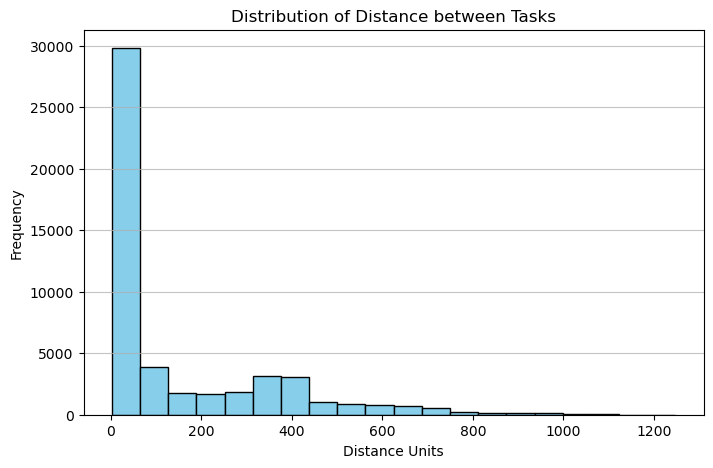

In [191]:
# Plot distribution of Distance (> 0)
plt.figure(figsize=(8, 5))
vals = oe_detailed.loc[oe_detailed["Dist_prev_to_curr"] > 0, "Dist_prev_to_curr"].dropna()
plt.hist(vals, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Distance between Tasks")
plt.xlabel("Distance Units")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [210]:
# Proportion of distance = 0
pct_dist_zero = (oe_detailed["Dist_prev_to_curr"] == 0).mean() * 100
print(f"Percentage of records with Distance = 0: {pct_dist_zero:.2f}%")
# Proportion < 50
pct_dist_less_50 = (oe_detailed["Dist_prev_to_curr"] < 50).mean() * 100
print(f"Percentage of records with Distance < 50: {pct_dist_less_50:.2f}%")
# Proportion > 750
pct_dist_greater_750 = (oe_detailed["Dist_prev_to_curr"] > 750).mean() * 100
print(f"Percentage of records with Distance > 750: {pct_dist_greater_750:.2f}%")

Percentage of records with Distance = 0: 27.92%
Percentage of records with Distance < 50: 66.46%
Percentage of records with Distance > 750: 0.98%


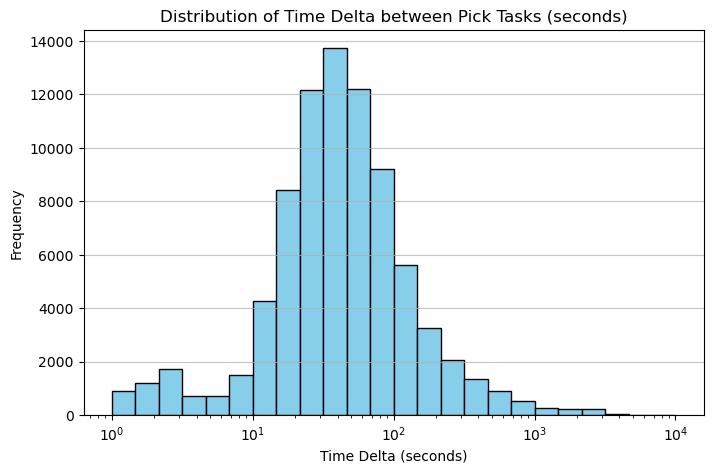

In [194]:
vals = oe["Time_Delta_sec"].dropna()
vals = vals[(vals > 0) & (vals < 10000)]

plt.figure(figsize=(8, 5))

plt.hist(vals,
         bins=np.logspace(0, np.log10(10000), 25),  # log-spaced bins
         color='skyblue',
         edgecolor='black')

plt.title("Distribution of Time Delta between Pick Tasks (seconds)")
plt.xlabel("Time Delta (seconds)")
plt.ylabel("Frequency")
plt.xscale("log")
plt.grid(axis='y', alpha=0.75)
plt.show()


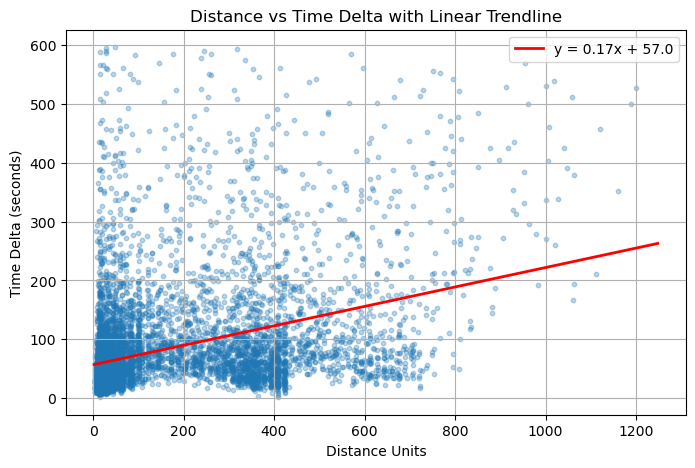

In [ ]:
# Plot scatter of Distance(>0) vs Time Delta(>0 and <600s)
plt.figure(figsize=(8, 5))
mask = (oe_detailed["Dist_prev_to_curr"] > 0) & (oe_detailed["Dist_prev_to_curr"] < 750) & (oe_detailed["Time_Delta_sec"] > 0) & (oe_detailed["Time_Delta_sec"] < 600)
plt.scatter(
    oe_detailed.loc[mask, "Dist_prev_to_curr"],
    oe_detailed.loc[mask, "Time_Delta_sec"],
    alpha=0.5,
    color='skyblue',
    edgecolor='black'
)
plt.title("Scatter Plot of Distance vs. Time Delta between Tasks")
plt.xlabel("Distance Units")
plt.ylabel("Time Delta (seconds)")
plt.grid(True)
plt.show()

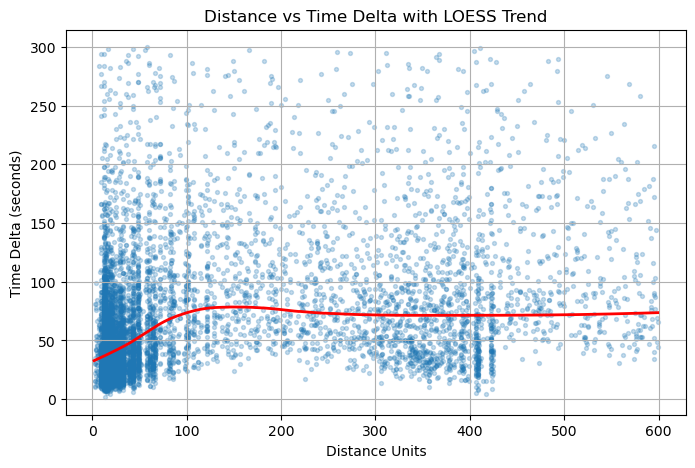

In [219]:
mask = (oe_detailed["Dist_prev_to_curr"] > 0) & \
        (oe_detailed["Dist_prev_to_curr"] < 600)    & \
       (oe_detailed["Time_Delta_sec"] > 0) & \
       (oe_detailed["Time_Delta_sec"] < 300)

plot_df = oe_detailed.loc[mask]

plt.figure(figsize=(8, 5))

# Light subsampled scatter for context
sample = plot_df.sample(n=8000, random_state=42)
plt.scatter(sample["Dist_prev_to_curr"],
            sample["Time_Delta_sec"],
            alpha=0.25, s=8)

# Non-linear smooth trendline (LOESS)
sns.regplot(
    data=plot_df,
    x="Dist_prev_to_curr",
    y="Time_Delta_sec",
    scatter=False,
    lowess=True,                # <-- non-linear smoother
    line_kws={"color": "red", "linewidth": 2}
)

plt.title("Distance vs Time Delta with LOESS Trend")
plt.xlabel("Distance Units")
plt.ylabel("Time Delta (seconds)")
plt.grid(True)
plt.show()


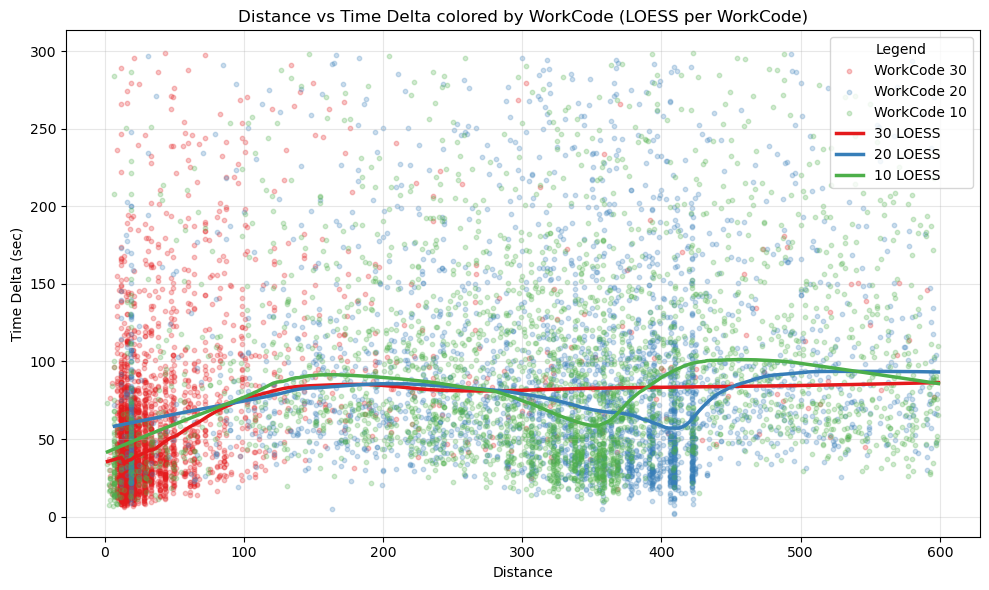

In [226]:


mask = (oe_detailed["Dist_prev_to_curr"] > 0) & \
        (oe_detailed["Dist_prev_to_curr"] < 600)    & \
       (oe_detailed["Time_Delta_sec"] > 0) & \
       (oe_detailed["Time_Delta_sec"] < 300)

plot_df = oe_detailed.loc[mask, ["Dist_prev_to_curr", "Time_Delta_sec", "WorkCode"]].copy()
plot_df["WorkCode"] = plot_df["WorkCode"].astype(str)

# Pick which workcodes to plot (optional: top K by frequency to avoid clutter)
top_k = 8
workcodes = plot_df["WorkCode"].value_counts().head(top_k).index.tolist()
plot_df = plot_df[plot_df["WorkCode"].isin(workcodes)].copy()

# --- LOWESS helper ---
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    def lowess_curve(x, y, frac=0.25):
        # returns sorted x and smoothed y
        out = lowess(y, x, frac=frac, return_sorted=True)
        return out[:, 0], out[:, 1]
except Exception:
    raise ImportError("statsmodels is required for LOWESS. Install with: pip install statsmodels")

# --- plotting ---
plt.figure(figsize=(10, 6))

# assign distinct colors
palette = sns.color_palette("Set1", n_colors=len(workcodes))
color_map = dict(zip(workcodes, palette))

# scatter (subsample per WorkCode for readability)
n_per_wc = 3000
for wc in workcodes:
    sub = plot_df[plot_df["WorkCode"] == wc]
    if len(sub) > n_per_wc:
        sub_scatter = sub.sample(n=n_per_wc, random_state=42)
    else:
        sub_scatter = sub

    plt.scatter(
        sub_scatter["Dist_prev_to_curr"],
        sub_scatter["Time_Delta_sec"],
        s=10,
        alpha=0.25,
        color=color_map[wc],
        label=f"WorkCode {wc}"
    )

# LOESS line per WorkCode
frac = 0.25  # increase for smoother, decrease for wigglier
for wc in workcodes:
    sub = plot_df[plot_df["WorkCode"] == wc].dropna()
    x = sub["Dist_prev_to_curr"].to_numpy()
    y = sub["Time_Delta_sec"].to_numpy()

    xs, ys = lowess_curve(x, y, frac=frac)
    plt.plot(xs, ys, linewidth=2.5, color=color_map[wc], label=f"{wc} LOESS")

plt.title("Distance vs Time Delta colored by WorkCode (LOESS per WorkCode)")
plt.xlabel("Distance")
plt.ylabel("Time Delta (sec)")
plt.grid(True, alpha=0.3)

# make legend manageable
plt.legend(loc="upper right", title="Legend")
plt.tight_layout()
plt.show()


In [205]:
import seaborn as sns

df = OE_Activity_with_deltas.copy()

# Use only valid positive deltas (exclude first task of day)
plot_df = df[df["Time_Delta_sec"] > 0].copy()

# Ensure WorkCode is string for consistent legend handling
plot_df["WorkCode"] = plot_df["WorkCode"].astype(str)

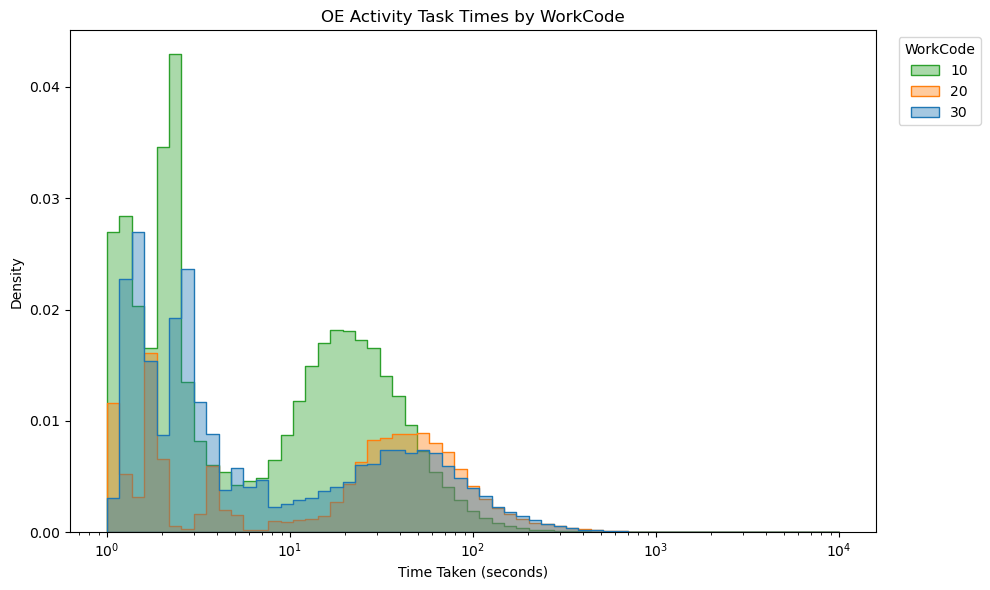

In [206]:
plt.figure(figsize=(10, 6))

# Explicitly control which WorkCodes appear and in what order
hue_order = ["10", "20", "30"]

sns.histplot(
    data=plot_df,
    x="Time_Delta_sec",
    hue="WorkCode",
    hue_order=hue_order,          # <-- forces 10, 20, 30 in legend
    palette="tab10",              # <-- distinct categorical colors
    element="step",
    stat="density",
    common_norm=False,
    bins=np.logspace(0, 4, 60),
    alpha=0.4
)

plt.xscale("log")
plt.xlabel("Time Taken (seconds)")
plt.ylabel("Density")
plt.title("OE Activity Task Times by WorkCode")

# Explicit legend so it always shows 10, 20, 30
plt.legend(title="WorkCode", labels=hue_order,
           bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()